# **Исследование поведения пользователей в приложение по продаже продуктов питания**

**Цель исследования:** выяснить при помощи A/A/B-тестирования какой шрифт лучше

**Ход исследования:**

- Изучение общей информации датасета
- Предобработка данных
- Изучение и проверка данных
- Воронка событий
- Анализ A/A/B-теста

# **Описание данных:**

**Файл /datasets/logs_exp.csv**

`EventName` — название события;

`DeviceIDHash` — уникальный идентификатор пользователя;

`EventTimestamp` — время события;

`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## **Откроем файл и изучим общую информацию**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
from plotly import graph_objects as go
import plotly.io as pio

In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv(r'C:\Users\niksmns\Desktop\user_behavior_in_a_food_app\logs_exp.csv', sep='\t')

In [3]:
def general_info(data):
    display(data.head(10))
    display(data.info())
    display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))
    display('Количество дубликатов:', data.duplicated().sum())
    display(data.columns)
    display(data.describe())

In [4]:
general_info(data)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,0
EventName,0.000000
DeviceIDHash,0.000000
EventTimestamp,0.000000
ExpId,0.000000


'Количество дубликатов:'

413

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

Изучили информацию о датасете. Пропусков обнаружено не было. Нашли дубликаты и видим необходимость поменять название колонок, а также поменять тип данных у `EventTimestamp`
</div>

## **Предобработка данных**

In [5]:
# приведем названия колонок к нижнему регистру
data.columns = data.columns.str.lower()

In [6]:
# немного поменяем названия колонок
data = data.rename(columns={
    'eventname': 'event_name',
    'deviceidhash': 'device_id',
    'eventtimestamp': 'event_time',
    'expid': 'exp_id',
})

In [7]:
# проверка колонок
data.columns

Index(['event_name', 'device_id', 'event_time', 'exp_id'], dtype='object')

In [8]:
# меняем тип данных
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

In [9]:
# добавляем отдельный столбец с датой
data['date'] = pd.to_datetime(data['event_time']).dt.date
data['date'] = pd.to_datetime(data['date'])

In [10]:
data.head(10)

,event_name,device_id,event_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


In [11]:
# удаляем дубликаты
data = data.drop_duplicates().reset_index(drop=True)
# проверяем
data.duplicated().sum()

0

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

Поменяли название колонок в соответствие хорошему стилю, поменяли тип данных у колонки с датой и временем и добавили отдельную столбец с датой. Также убрали все явные дубликаты
</div>

## **Изучение и проверка данных**

In [12]:
# выведем сколько всего событий 
print('Событий в логе:', data['event_name'].count())

Событий в логе: 243713


In [13]:
# выведем общее количество уникальных пользователей
print('Пользователей в логе:', data['device_id'].nunique())

Пользователей в логе: 7551


In [14]:
print('В среднем событий приходится на пользователя:', round(data['event_time'].count() / data['device_id'].nunique()))

В среднем событий приходится на пользователя: 32


In [15]:
print('Минимальная дата:', data['date'].min())
print('Максимальная дата:', data['date'].max())

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


In [16]:
print('Отрезок времени проведение эксперимента:', data['date'].max() - data['date'].min())

Отрезок времени проведение эксперимента: 13 days 00:00:00


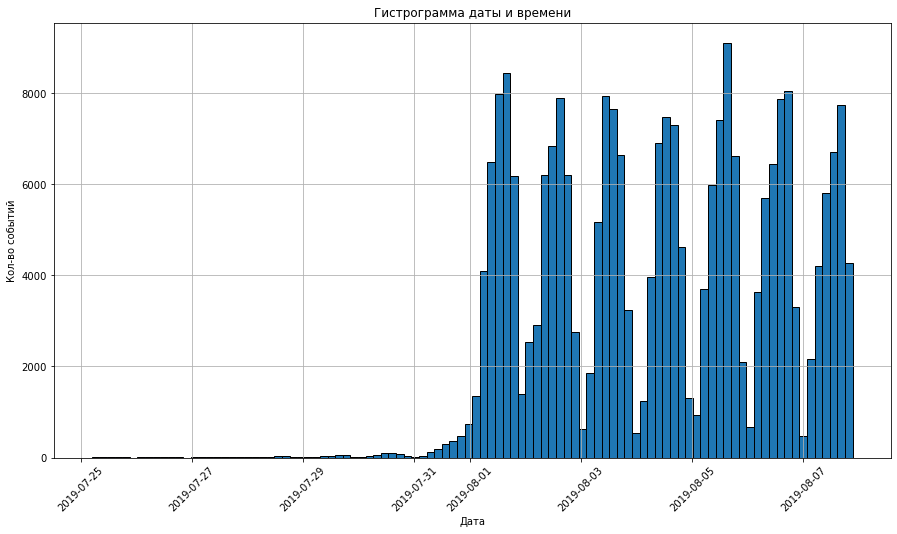

In [17]:
data['event_time'].hist(bins=100, figsize=(15,8), ec='black');
plt.title('Гистрограмма даты и времени')
plt.ylabel('Кол-во событий')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

In [18]:
data.pivot_table(index='date', values='event_name', aggfunc='count')

,event_name
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

У нас есть данные за 2 недели. Данные за первую неделю считаю неполными из-за малого количества. По сути наиболее информативна была вторая неделя из-за выского кол-ва действий
</div>

In [19]:
# удаляем неполную данными неделю
data_clean = data[data['date'] > '2019-07-31']

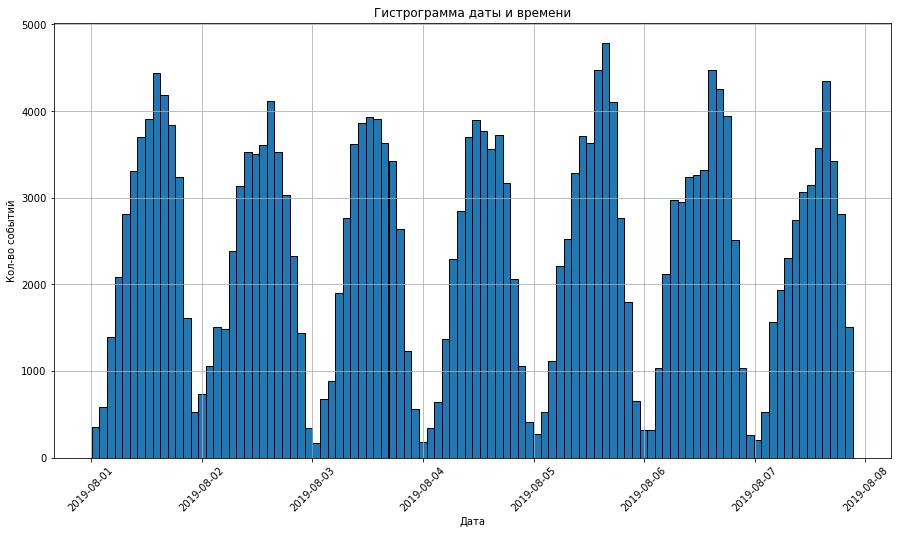

In [20]:
data_clean['event_time'].hist(bins=100, figsize=(15,8), ec='black');
plt.title('Гистрограмма даты и времени')
plt.ylabel('Кол-во событий')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

In [21]:
total_events = data['event_name'].count()
total_events_clean = data_clean['event_name'].count()
loss_data = round((data['event_name'].count() - data_clean['event_name'].count()) / data['event_name'].count() * 100, 3)

print('Сырые данны| Всего событий:', total_events)
print('Очищенные данные| Всего событий:', total_events_clean)
print('Потеряли данных, %:', loss_data)

Сырые данны| Всего событий: 243713
Очищенные данные| Всего событий: 240887
Потеряли данных, %: 1.16


In [22]:
total_user = data['device_id'].nunique()
total_user_clean = data_clean['device_id'].nunique()
loss_user = round((data['device_id'].nunique() - data_clean['device_id'].nunique()) / data['device_id'].nunique() * 100, 3)

print('Сырые данные| Всего пользователей в логе:', total_user)
print('Очищенные данные| Всего пользователей в логе:', total_user_clean)
print('Потеряли данных, %:', loss_user)

Сырые данные| Всего пользователей в логе: 7551
Очищенные данные| Всего пользователей в логе: 7534
Потеряли данных, %: 0.225


In [23]:
avg_ev_us = round(data['event_time'].count() / data['device_id'].nunique(), 3)
avg_ev_us_clean = round(data_clean['event_time'].count() / data_clean['device_id'].nunique(), 3)

print('Сырые данные| В среднем событий приходится на пользователя:', avg_ev_us)
print('Очищенные данные| В среднем событий приходится на пользователя:', avg_ev_us_clean)

Сырые данные| В среднем событий приходится на пользователя: 32.276
Очищенные данные| В среднем событий приходится на пользователя: 31.973


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

В ходе очистки было потеряно 1.16% событий, 0.225% пользователей, а среднее количество событий так и осталось 32
</div>

In [24]:
# проверка пользователей из всех экспериментальных групп
data_clean.pivot_table(index='exp_id', values='device_id', aggfunc='nunique')

,device_id
exp_id,
246,2484
247,2513
248,2537


In [25]:
# проверим пользователей, которые могут быть в нескольких группах
users_duplicated_group = data_clean.groupby('device_id').agg({'exp_id': ['nunique', 'unique']})
users_duplicated_group.columns = ['groups', 'group_names']
users_duplicated_group = users_duplicated_group.query('groups > 1')
users_duplicated_group.head()

,groups,group_names
device_id,,


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

Изучили и проверили данные, выяснили количества событий, пользователей, сколько событий приходится на пользователя и узнали минимальную и маскимальную дату, а также отрезок времени проведения эксперимента. Построили гистограмму и нашли с помощью неё и сводной таблицы неполные данные. Построили гистрограмму по очищенным данным. Вычислили сколько было потеряно данных в ходе очистки. Проверили пользователей из групп и выяснили, что нет пользователей присутсвующих в нескольких группах сразу
</div>

## **Воронка событий**

In [26]:
# выведем  какие есть события и их количества
events_count = data_clean['event_name'].value_counts().reset_index()
events_count

,index,event_name
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

В воронку собыйтий не вписывается событие `Tutorial`, ибо это действие совершается перед использованием продукта, а количество пользователей там очень мало, вероятно не все люди заинтересованы в их просмотрах, поэтому переходят сразу к главному экрану. Уберем это событие, дабы не искажать результаты данных
</div>

In [27]:
# подсчитаем сколько пользователей совершали каждое из событий
funnel_sales = (
    data_clean.query('event_name != "Tutorial"')
    .groupby('event_name')
    .agg({'device_id': 'nunique'})
    .reset_index()
    .sort_values(by='device_id', ascending=False)
    .reset_index()
    .rename(columns={'device_id': 'total_device'}))

funnel_sales

,index,event_name,total_device
0,1,MainScreenAppear,7419
1,2,OffersScreenAppear,4593
2,0,CartScreenAppear,3734
3,3,PaymentScreenSuccessful,3539


In [28]:
# подсчитаем долю пользователей, которые хоть раз совершали событие 
funnel_sales['share, %'] = round(funnel_sales['total_device'] / data_clean['device_id'].nunique() * 100, 2)
funnel_sales

,index,event_name,total_device,"share, %"
0,1,MainScreenAppear,7419,98.47
1,2,OffersScreenAppear,4593,60.96
2,0,CartScreenAppear,3734,49.56
3,3,PaymentScreenSuccessful,3539,46.97


In [45]:
# построим график воронки событий долей пользователей, которые хоть раз совершали событие
fig = go.Figure(go.Funnel(
    y = funnel_sales['event_name'],
    x = funnel_sales['share, %']))
fig.update_layout(title_text='Воронка событий долей пользователей, которые хоть раз совершали событие')
fig.show()
pio.write_html(fig, file='figure.html', auto_open=True)

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

По сути график у нас уже выстроился в последовательную воронку событий, которая выглядит так
    
`Главный экран`  →  `Экран предложений`  →  `Экран корзины`  →  `Экран оплаты`
</div>

In [30]:
# подсчитаем доли пользователей, которые проходят на следующий шаг воронки
funnel_sales['device_share_passes, %'] = round(funnel_sales['total_device'] / funnel_sales['total_device'].shift(1), 3) * 100
funnel_sales

,index,event_name,total_device,"share, %","device_share_passes, %"
0,1,MainScreenAppear,7419,98.47,NaN
1,2,OffersScreenAppear,4593,60.96,61.9
2,0,CartScreenAppear,3734,49.56,81.3
3,3,PaymentScreenSuccessful,3539,46.97,94.8


In [31]:
# построим воронки событий долей пользователей, которые проходят на следующий шаг
fig = go.Figure(go.Funnel(
    y = funnel_sales['event_name'],
    x = funnel_sales['device_share_passes, %'],
    textposition = 'inside'))
fig.update_layout(title_text='Воронка событий долей пользователей, которые проходят на следующий шаг воронки')
fig.show()
pio.write_html(fig, file='figure.html', auto_open=True)

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

Можем заметить, что больше всего пользователей теряется на первом действие `38.1%`
</div>

In [32]:
print('От главного экрана до экрана оплаты доходят', \
      round(funnel_sales['total_device'][3] / funnel_sales['total_device'][0] * 100, 2), '% пользователей')

От главного экрана до экрана оплаты доходят 47.7 % пользователей


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">
    
В ходе изучения данных, построили воронку событий и на её основе определили какие доли пользователей проходят на следующий этап и долю пользователей дошедших с певого этапа до последнего

Выяснили, что на первом этапе теряется больше всего пользователей `38.1%`, а от главного экрана до экрана оплаты доходят `47.7%` пользователей
</div>

## **Изучение результатов эксперимента**

In [33]:
# выведем кол-во уникальных пользователей по группам
users_exp = data_clean.pivot_table(index='exp_id', values='device_id', aggfunc='nunique').reset_index()
users_exp

,exp_id,device_id
0,246,2484
1,247,2513
2,248,2537


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

В группах достаточное и примерно одинакое кол-во пользователей, а это хорошо для проведения A/A теста

**Критерии успешного A/A-теста:**

- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

</div>

In [34]:
# выведем разницу кол-ва пользователей между группами 
group_246 = int(users_exp[users_exp['exp_id'] == 246]['device_id'])
group_247 = int(users_exp[users_exp['exp_id'] == 247]['device_id'])
print('Кол-во пользователей в различных группах различается на', round(100 - (group_246 / group_247 * 100), 2), '%')

Кол-во пользователей в различных группах различается на 1.15 %


### А/А-тестирование

**Cформулируем гипотезы:**

H0: различий в долях уникальных пользователей между группами нет

H1: различий в долях уникальных пользователей между группами есть

***Воспользуемся методом z-тест(z-критерий Фишера) и обозначим критический уровень статистической значимости 5%***

In [35]:
# критический уровень статистической значимости
alpha = .05
 
# число пользователей в группе 1 и группе 2:
users = np.array([data_clean['device_id'].nunique(),
                        data_clean['device_id'].nunique()])

# число пользователей, совершивших событие в группе 1 и группе 2
success = np.array([data_clean[data_clean['exp_id'] == 246]['device_id'].nunique(), 
                        data_clean[data_clean['exp_id'] == 247]['device_id'].nunique()])

# пропорции успехов в группах:
p1 = success[0]/users[0]
p2 = success[1]/users[1]
    
# пропорция успехов в комбинированном датасете:
p_combined = (success[0] + success[1]) / (users[0] + users[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/users[0] + 1/users[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# удваиваем результат, так как тест двусторонний 
p_value = (1 - distr.cdf(abs(z_value))) * 2 
    
print('p-значение: ', p_value)

if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.615804820320411
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">
    
В ходе проведенного A/A-теста по группам выяснили, что статистически достоверного отличия при заданном уровне значимости нет. Проведём ещё A/A-тест по событиям между группами.
</div>

In [36]:
funnel_group = (
    data_clean.groupby(['event_name', 'exp_id'])
    .agg({'device_id': 'nunique'})
    .sort_values(by=['exp_id','device_id'], ascending=False)
    .reset_index())

funnel_group = funnel_group.query('event_name != "Tutorial"')
funnel_group

,event_name,exp_id,device_id
0,MainScreenAppear,248,2493
1,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
3,PaymentScreenSuccessful,248,1181
5,MainScreenAppear,247,2476
6,OffersScreenAppear,247,1520
7,CartScreenAppear,247,1238
8,PaymentScreenSuccessful,247,1158
10,MainScreenAppear,246,2450
11,OffersScreenAppear,246,1542


In [37]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = funnel_group.query('exp_id == 246')['event_name'],
    x = funnel_group.query('exp_id == 246')['device_id'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = funnel_group.query('exp_id == 247')['event_name'],
    x = funnel_group.query('exp_id == 247')['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = funnel_group.query('exp_id == 248')['event_name'],
    x = funnel_group.query('exp_id == 248')['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.update_layout(title_text='Воронка событий по группам')
fig.show()
pio.write_html(fig, file='figure.html', auto_open=True)

In [38]:
# функция проверки гипотезы о равенстве долей с учётом поправки Бонферрони для множественого тестирования

def z_test(data1, data2, event_name, alpha, n):
 
    # критический уровень статистической значимости c поправкой Бонферрони
    alpha_b = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    users = np.array([data1['device_id'].nunique(), 
                        data2['device_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([data1[data1['event_name'] == event_name]['device_id'].nunique(), 
                        data2[data2['event_name'] == event_name]['device_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/users[0]
    p2 = success[1]/users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (users[0] + users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/users[0] + 1/users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    # удваиваем результат, так как тест двусторонний 
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    
    print('Событие:', event_name)
    print('p-value: ', p_value)

    if p_value < alpha_b:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

У нас получается 4 события, соответственно увеличивается шанс ложнопозитивного результата, для это и используем поправку Бонферрон
</div>

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

**Cформулируем гипотезы для всех событий:**

**Нулевая гипотеза H₀:** различий в долях уникальных пользователей между группами по событиям нет

**Альтернативная гипотеза H₁:** различий в долях уникальных пользователей между группами по событиям есть
    
*α* = **5**% - уровень значимости

**Метод проверки гипотез:** z-тест(z-критерий Фишера)
</div>

In [39]:
# проверим, есть ли статистически значимая разница между группами 246 и 247
for event_name in funnel_group['event_name'].unique():
    z_test(data_clean[data_clean['exp_id'] == 246], data_clean[data_clean['exp_id'] == 247], event_name, 0.05, 4)
    print()

Событие: MainScreenAppear
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

По результатам A/A-теста по событиям в группах `246` и `247`, видим, что статистически достоверного отличия при заданном уровне значимости c поправкой Бенферрони нет. Это значит, что можно приступать к A/B-тестированию
</div>

### A/B-тестирование

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">

**Cформулируем гипотезы для всех событий A/B-теста:**

**Нулевая гипотеза H₀:** различий в долях уникальных пользователей между группами по событиям нет

**Альтернативная гипотеза H₁:** различий в долях уникальных пользователей между группами по событиям есть
    
*α* = **5**% - уровень значимости

**Метод проверки гипотез:** z-тест(z-критерий Фишера)
</div>

In [40]:
# проверим, есть ли статистически значимая разница по событиям между группами 246 и 248
for event_name in funnel_group['event_name'].unique():
    z_test(data_clean[data_clean['exp_id'] == 246], data_clean[data_clean['exp_id'] == 248], event_name, 0.05, 12)
    print()

Событие: MainScreenAppear
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [41]:
# проверим, есть ли статистически значимая разница по событиям между группами 247 и 248
for event_name in funnel_group['event_name'].unique():
    z_test(data_clean[data_clean['exp_id'] == 247], data_clean[data_clean['exp_id'] == 248], event_name, 0.05, 12)
    print()

Событие: MainScreenAppear
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [42]:
# проверим, есть ли статистически значимая разница по событиям между обьедененными группами 247 и 248
for event_name in funnel_group['event_name'].unique():
    z_test(data_clean[data_clean['exp_id'] != 248], data_clean[data_clean['exp_id'] == 248], event_name, 0.05, 12)
    print()

Событие: MainScreenAppear
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">
    
Видим, что по итогу всех A/B-тестов статистически достоверного отличия при заданном уровне значимости c поправкой Бенферрони нет, а это значит, что новый шрифт не повлиял никаким образом на приложение. Применение критического уровня статистической значимости в 0.05 даст более значимый результат, так при тестирование групп 246 и 248 в событие CartScreenAppear при статистической значимости в 0.1, результат был бы разницой между долями
</div>

## **Вывод**

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px">
<br>
<b>1. Открыли файлы и изучили данные</b>
    
- пропусков обнаружено не было
- были обнаружены дубликаты
- названия колонок не соответсвует хорошему стилю
- обнаружен некорректный тип данных EventTimestamp

<b>2. Провели предобработку</b>
    
- привели названия колонок к нижнему регистру и переименовали как удобно
- изменили тип данных у EventTimestamp
- добавили новый столбец с датой
- выявили посетителей, которые состоят в обоих группах AB-теста
    
<b>3. Изучили и проверили данные</b>

- выяснили количества событий, пользователей, сколько событий приходится на пользователя
- узнали минимальную и максимальную дату и отрезок проведения эксперимента
- отсеяли неполные данные
- вычислили сколько было потеряно данных в ходе очистки
- убедились, что нет пользователей находящихся в нескольких группах сразу
    
<b>4. Построили воронку событий</b>
    
- построили воронку событий
- убрали событие `Tutorial`, которое могло бы исказить результаты A/A/B-тестирования
- определили какие доли пользователей проходят на следующий этап и долю пользователей дошедших с певого этапа до последнего
    
<b>5. Изучили результаты эксперимента</b>

- провели A/A-тестирование
- провели A/B-тестирование
- провели A/A/B-тестирование

<br>
<br>
<b>Целью исследования было выяснить при помощи A/A/B-тестирования какой шрифт лучше</b>
    

<br>
<br>
<b>В ходе проведения A/A/B-тестирования результаты показали, что при:</b>

1. A/A-тестирование статистически достоверного отличия не было, что позволило приступить к дальнейшим действиям
2. A/B-тестирование статистически достоверного отличия не было
3. A/A/B-тестирование статистически достоверного отличия не было
    
<b>Вывод напрашивается сам, что новый шрифт не повлиял на приложение.</b>

<br>
<br>

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid orange 2px; padding: 20px">
<b>Рекомендации:</b>

Завершить проведение теста, признать его успешным. Признать отсутствие различий между группами.

Изменение шрифтов можно провести, однако это не увеличит показатели
</div>    
</div>